## Keras implementation of https://junyanz.github.io/CycleGAN/

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [2]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False


Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input 
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten, Dropout
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam




In [4]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization



In [5]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)

def BASIC_D(isize, nc, ndf, n_extra_layers=0):
    assert isize%2==0
    _ = inputs = Input(shape=( isize, isize,nc))
    _ = Conv2D(filters=ndf, kernel_size=4, strides=2, use_bias=False,
                        padding = "same",
                        kernel_initializer = conv_init, 
                        name = 'initial.conv.{0}-{1}'.format(ndf,nc)             
                        ) (_)
    _ = LeakyReLU(alpha=0.2, name = 'initial.relu.{0}'.format(ndf))(_)
    csize, cndf = isize// 2, ndf
    while csize > 5:
        assert csize%2==0
        in_feat = cndf
        out_feat = cndf*2
        _ = Conv2D(filters=out_feat, kernel_size=4, strides=2, use_bias=False,
                        padding = "same",
                        kernel_initializer = conv_init,
                        name = 'pyramid.{0}-{1}.conv'.format(in_feat, out_feat)             
                        ) (_)
        if 0: # toggle batchnormalization
            _ = BatchNormalization(name = 'pyramid.{0}.batchnorm'.format(out_feat),                                   
                                   momentum=0.9, axis=1, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init, 
                                  )(_, training=1)        
        _ = LeakyReLU(alpha=0.2, name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cndf = (csize+1)//2, cndf*2
    _ = Conv2D(filters=1, kernel_size=csize, strides=1, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'final.{0}-{1}.conv'.format(cndf, 1)         
                        ) (_)
    outputs = Flatten()(_)
    return Model(inputs=inputs, outputs=outputs)

In [6]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [7]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
λ = 10 

loadSize = 143
imageSize = 128
batchSize = 5
lrD = 2e-4
lrG = 2e-4


In [8]:
netDA = BASIC_D(imageSize,nc_in, ndf)
netDB = BASIC_D(imageSize,nc_out, ndf)
netDA.summary()
from keras.models import load_model
# netDB = load_model('model/DB_2_10.h5')
# netDA = load_model('model/DA_2_10.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
initial.conv.64-3 (Conv2D)   (None, 64, 64, 64)        3072      
_________________________________________________________________
initial.relu.64 (LeakyReLU)  (None, 64, 64, 64)        0         
_________________________________________________________________
pyramid.64-128.conv (Conv2D) (None, 32, 32, 128)       131072    
_________________________________________________________________
pyramid.128.relu (LeakyReLU) (None, 32, 32, 128)       0         
_________________________________________________________________
pyramid.128-256.conv (Conv2D (None, 16, 16, 256)       524288    
_________________________________________________________________
pyramid.256.relu (LeakyReLU) (None, 16, 16, 256)       0         
__________

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model

netGB = UNET_G(imageSize, nc_in, nc_out, ngf)
netGA = UNET_G(imageSize, nc_out, nc_in, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))

netGA.summary()
# netGB = load_model('model/GB_2_10.h5')
# netGA = load_model('model/GA_2_10.h5')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv_128 (Conv2D)               (None, 64, 64, 64)   3136        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 64, 64, 64)   0           conv_128[0][0]                   
__________________________________________________________________________________________________
conv_64 (Conv2D)                (None, 32, 32, 128)  131072      leaky_re_lu_7[0][0]              
__________________________________________________________________________________________________
batch_norm

In [10]:
from keras.layers.merge import _Merge

class RandomWeightedAverage(_Merge):


    def _merge_function(self, inputs):
        weights = K.random_uniform((batchSize, 1, 1, 1))
        print(weights * inputs[0])
        return Input((weights * inputs[0]) + ((1 - weights) * inputs[1]))

In [11]:
from keras.optimizers import RMSprop, SGD, Adam

In [12]:

# loss_fn = lambda y_pred, y_true : (K.mean(y_true,y_pred))

# #loss_gp = lambda y_pred, averaged_samples: K.mean(gradient_penalty_weight*(1 - K.sqrt((K.gradients(y_pred,averaged_samples)[0]))))
# loss_gp = lambda y_pred, netD: K.mean(gradient_penalty_weight*K.square(1 - K.sqrt(K.sum(K.square(K.gradients(netD([y_pred]),[y_pred])[0])))))


def gradient_penalty_loss(y_pred, averaged_samples):

    gradients = (K.gradients(y_pred, averaged_samples)[0])
    # compute the euclidean norm by squaring ...
#     gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
#     gradients_sqr_sum = K.sum(gradients_sqr,axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
#     gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradients)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)


def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)




In [32]:
ϵ_input = K.placeholder(shape=(None,1,1,1))
def D_loss(netD, real, fake, rec):


  
    
    netD_mixed_input = Input(shape=(imageSize, imageSize, 3),
                                tensor = ϵ_input * real + (1-ϵ_input) * fake)
    
    grad_mixed = K.gradients(netD(netD_mixed_input), [netD_mixed_input])[0]
    norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
    grad_penalty = K.mean(K.square(norm_grad_mixed-1))

    loss_D_real = K.mean(netD(real))
    loss_D_fake = K.mean(netD(fake))

    loss_G = -loss_D_fake
    loss_D = loss_D_fake - loss_D_real + λ*grad_penalty
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc, loss_D_real, loss_D_fake

loss_DA, loss_GA, loss_cycA, loss_DA_real, loss_DA_fake= D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cyc, loss_DB_real, loss_DB_fake= D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB

In [40]:
loss_G = loss_GA+loss_GB+λ*loss_cyc
loss_D = loss_DA+loss_DB

weightsD = netDA.trainable_weights + netDB.trainable_weights
weightsG = netGA.trainable_weights + netGB.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A, real_B,ϵ_input],[loss_DA, loss_DA_real, loss_DA_fake, loss_DB, loss_DB_real, loss_DB_fake], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates )

In [41]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img

#data = "edges2shoes"
data = "azur2rojo"
train_A = load_data('CycleGAN/{}/trainA/*.jpg'.format(data))
train_B = load_data('CycleGAN/{}/trainB/*.jpg'.format(data))


assert len(train_A) and len(train_B)

In [42]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

In [43]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

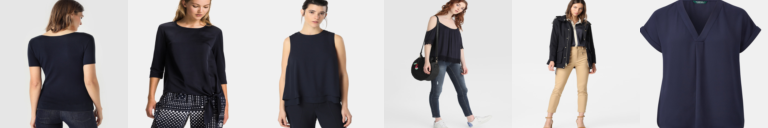

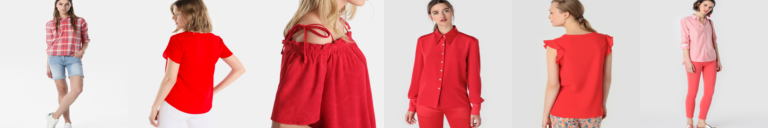

In [44]:
train_batch = minibatchAB(train_A, train_B, 6)

_, A, B = next(train_batch)
showX(A)
showX(B)
del train_batch, A, B

In [45]:
def showG(A,B):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    showX(arr, 3)

In [ ]:


import time
from IPython.display import clear_output
t0 = time.time()
niter = 160
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum=errDA_realsum=errDB_realsum=errDA_fakesum=errDB_fakesum = 0
train_ratio = 100
display_iters = 1
#val_batch = minibatch(valAB, 6, direction)
train_batch_D = minibatchAB(train_A, train_B, batchSize)
train_batch_G = minibatchAB(train_A, train_B, batchSize)
checkpoint = 1
old_epoch =0
while epoch < niter: 
    if(epoch > 25):
        train_ratio = 5
    _, A, B = next(train_batch_D) 
    ϵ = np.random.uniform(size=(batchSize, 1, 1 ,1))
    for i in range(train_ratio):
        errDA, errDA_real, errDA_fake, errDB, errDB_real, errDB_fake  = netD_train([A, B, ϵ])
        errDA_sum +=errDA
        errDB_sum +=errDB
        errDA_realsum +=errDA_real
        errDB_realsum +=errDB_real
        errDA_fakesum +=errDA_fake
        errDB_fakesum +=errDB_fake

        _, A, B = next(train_batch_D) 
    
    
    # epoch, trainA, trainB = next(train_batch)
    epoch, A, B = next(train_batch_G) 
    errGA, errGB, errCyc = netG_train([A, B])
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    gen_iterations+=1
        
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        clear_output()
#         print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
#         % (epoch, niter, gen_iterations, errDA_sum/(display_iters*5), errDB_sum/(display_iters*5),
#            errGA_sum/display_iters, errGB_sum/display_iters, 
#            errCyc_sum/display_iters), time.time()-t0)
        print(' Loss_D: %f %f Loss_real %f %f Loss_fake %f %f Loss_G: %f %f loss_cyc %f %f'
                     % ( errDA, errDB,
                        errDA, errDB_real,
                        errDA_fake, errDB_fake,
           errGA, errGB, 
           errCyc, time.time()-t0))
        print('epoch %d' %(epoch))
        _, A, B = train_batch_G.send(4)
        showG(A,B)        
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
#     keras.callbacks.ModelCheckpoint('model/',  verbose=0, save_weights_only=False, mode='auto', period=1)
    if(epoch%10 == 0 and old_epoch != epoch):
        netGA.save('../../raghavsidata/wcycle-gan/azur2rojo/GA_2'+str(checkpoint)+'.h5')
        netGB.save('../../raghavsidata/wcycle-gan/azur2rojo/GB_2'+str(checkpoint)+'.h5')
        netDA.save('../../raghavsidata/wcycle-gan/azur2rojo/DA_2'+str(checkpoint)+'.h5')
        netDB.save('../../raghavsidata/wcycle-gan/azur2rojo/DB_2'+str(checkpoint)+'.h5')
        checkpoint = checkpoint + 1
        if(checkpoint > 3):
            checkpoint = 1
    old_epoch = epoch
